In [11]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

print('All modules imported.')

All modules imported.


# 1 Reload the preprocessed data

In [2]:
# 1 Reload the preprocessed data

pickle_file = './pre-traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2 Model Architecture

## 2.1 VGG

In [3]:
from tensorflow.contrib.layers import flatten

def VGG(x, KEEP_PROB):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Input = 32x32x3. Output = 28x28x6.
    # Convolutional. 
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 3, 6), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
       
    # Layer 2: Input = 14x14x6. Output = 10x10x16.
    # Convolutional. 
    conv2_w = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool1, conv2_w, [1, 1, 1, 1], 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
      
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)   
    
    # Layer 3: Input = 1536. Output = 800.
    # Fully Connected. 
    full1_w = tf.Variable(tf.truncated_normal((400, 120), mu, sigma))
    full1_b = tf.Variable(tf.zeros(120))
    full1 = tf.matmul(flat, full1_w) + full1_b
    # Activation.
    full1 = tf.nn.relu(full1) 
    # Dropout
    full1 = tf.nn.dropout(full1, KEEP_PROB)
    
    # Layer 4: Input = 800. Output = 400.
    # Fully Connected. 
    full2_w = tf.Variable(tf.truncated_normal((120, 84), mu, sigma))
    full2_b = tf.Variable(tf.zeros(84))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, KEEP_PROB)
    
    # Layer 5: Fully Connected. Input = 400. Output = 200.
    full3_w = tf.Variable(tf.truncated_normal((84, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b
    
    return logits

# 3 Training

## 3.1 Strategy

In [4]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 0.0005
EPOCHS = 35
BATCH_SIZE = 128

# Train method
logits = VGG(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

## 3.2 Evaluation

In [5]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 3.3 Train the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [6]:
%%time
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './model/lenet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Validation Accuracy = 0.364
EPOCH 2 : Validation Accuracy = 0.535
EPOCH 3 : Validation Accuracy = 0.686
EPOCH 4 : Validation Accuracy = 0.752
EPOCH 5 : Validation Accuracy = 0.804
EPOCH 6 : Validation Accuracy = 0.826
EPOCH 7 : Validation Accuracy = 0.861
EPOCH 8 : Validation Accuracy = 0.872
EPOCH 9 : Validation Accuracy = 0.886
EPOCH 10 : Validation Accuracy = 0.886
EPOCH 11 : Validation Accuracy = 0.901
EPOCH 12 : Validation Accuracy = 0.906
EPOCH 13 : Validation Accuracy = 0.904
EPOCH 14 : Validation Accuracy = 0.910
EPOCH 15 : Validation Accuracy = 0.909
EPOCH 16 : Validation Accuracy = 0.920
EPOCH 17 : Validation Accuracy = 0.922
EPOCH 18 : Validation Accuracy = 0.927
EPOCH 19 : Validation Accuracy = 0.927
EPOCH 20 : Validation Accuracy = 0.935
EPOCH 21 : Validation Accuracy = 0.930
EPOCH 22 : Validation Accuracy = 0.933
EPOCH 23 : Validation Accuracy = 0.937
EPOCH 24 : Validation Accuracy = 0.936
EPOCH 25 : Validation Accuracy = 0.935
EPOCH 26 : Validation 

# 4 Testing

## 4.1 Test the model on testing dataset

INFO:tensorflow:Restoring parameters from ./model/lenet.ckpt


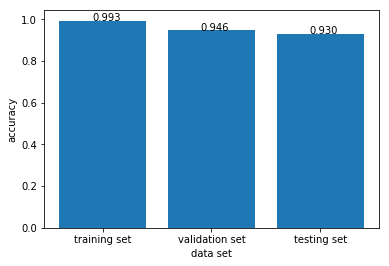

In [7]:
with tf.Session() as sess:
    saver.restore(sess, './model/lenet.ckpt')
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

## 4.2 Test the Model on New Images
To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type. You may find signnames.csv useful as it contains mappings from the class id (integer) to the actual sign name.

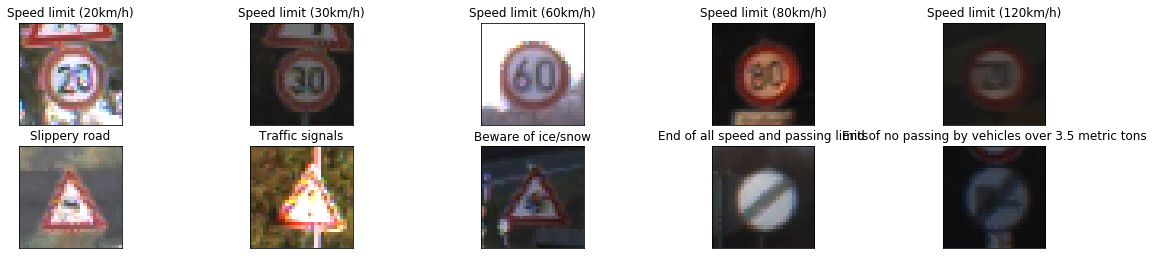

In [12]:
gt_images = []
gt_labels = []

with open('./test_images/labels.csv') as f:
    gt_labels = [row[7] for row in csv.reader(f)]
# print(gt_labels)

for i in range(1, 11):
    img = Image.open('./test_images/' + str(i) +'.ppm')
    img.save('./test_images/' + str(i) +'.jpg')
    gt_images.append(plt.imread('./test_images/' + str(i) +'.ppm'))
# print(gt_images)

plt.figure(figsize=(20, 20))
for i in range(len(gt_images)):
    plt.subplot(9, 5, i + 1), plt.imshow(gt_images[i]), plt.title(signnames[int(gt_labels[i])])
    plt.xticks([]), plt.yticks([])
    
gt_images = np.array(gt_images)
gt_labels = np.array(gt_labels)
    
# Normalization
gt_images = gt_images.astype(np.float32) / 128. - 1.

### Predict the Sign Type for Each Image

In [13]:
with tf.Session() as sess:
    saver.restore(sess, './model/lenet.ckpt')
    test_accuracy = evaluate(gt_images, gt_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))   
    logits_value = sess.run(logits, feed_dict={x: gt_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from ./model/lenet.ckpt
Test Accuracy = 1.000
Predict the Sign Type for Each Image
[ 0  1  3  5  8 23 26 30 32 42]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web
For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

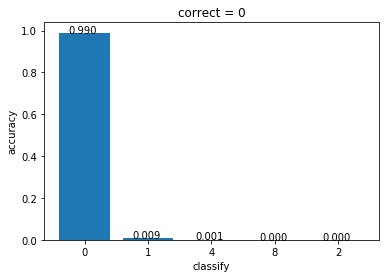

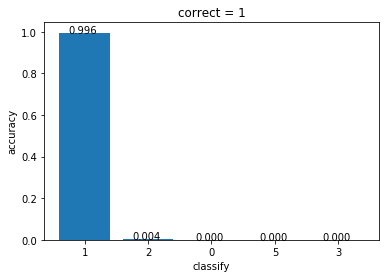

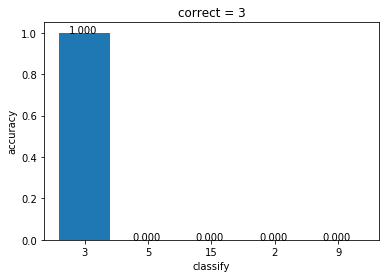

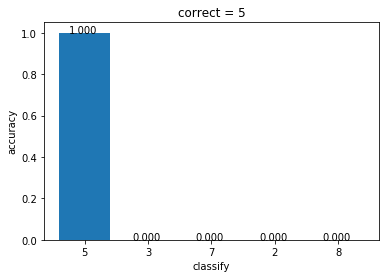

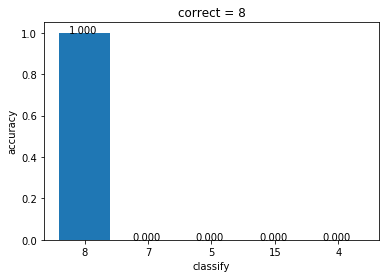

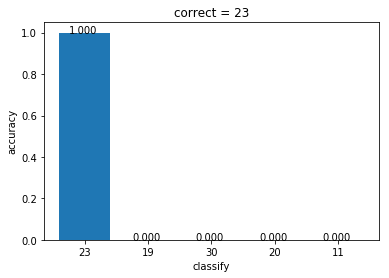

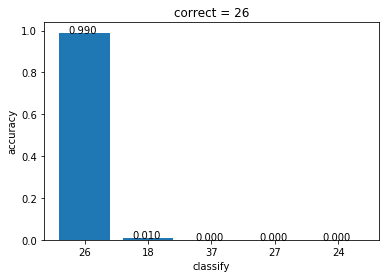

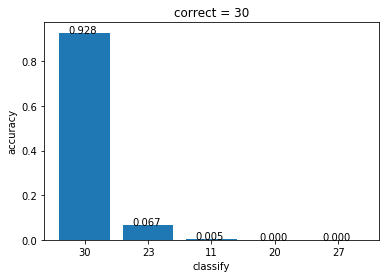

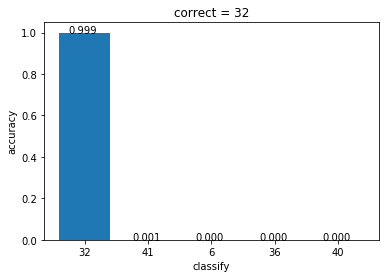

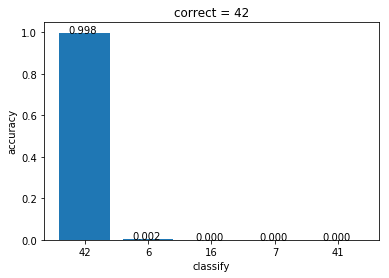

In [14]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

def plt_bar(values, indicex, answer):
    plt.bar(range(5), values)
    plt.xlabel('classify')
    plt.ylabel('accuracy')
    plt.xticks(range(5), indicex)
    plt.title("correct = "+answer)
    for x_,y_ in zip(range(5), values):
        plt.text(x_ - 0.25, y_, '%.3f'%y_)
    plt.show()

for i in range(10):
    plt_bar(top5.values[i], top5.indices[i], gt_labels[i])